In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install transformers

     |████████████████████████████████| 3.1 MB 8.6 MB/s 
     |████████████████████████████████| 596 kB 89.5 MB/s 
     |████████████████████████████████| 3.3 MB 69.5 MB/s 
     |████████████████████████████████| 895 kB 70.1 MB/s 
     |████████████████████████████████| 61 kB 638 kB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
%cd /content/drive/MyDrive/ECE 661/assignment-3/ECE661_2021F_HW3

/content/drive/MyDrive/ECE 661/assignment-3/ECE661_2021F_HW3


In [ ]:
import functools
import sys
import numpy as np
import tqdm
import random
import re
from sklearn.model_selection import train_test_split
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from collections import Counter
from torch.utils.data import Dataset
import transformers
from transformer import TransformerEncoder
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [ ]:
# USE_PRETRAINED_TOKENIZER = True
PAD_INDEX = 0
UNK_INDEX = 1
PAD_TOKEN = '<pad>'
UNK_TOKEN = '<unk>'
BATCH_SIZE = 16
MAX_LENGTH = 256
HIDDEN_DIM = 256
OUTPUT_DIM = 2
N_LAYERS = 3
ATTN_HEADS = 4
DROPOUT_RATE = 0.1
LR = 3e-4

In [ ]:
seed = 0
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

In [ ]:
class IMDB(Dataset):
    def __init__(self, x, y, tokenizer, max_length=256, mode='pre-train') -> None:
        """
        :param split: can be either "train", "val" or "test".
        :param tokenizer: a simple tokenizer object.
        """
        self.x = x
        self.y = y
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.mode = mode

    def __getitem__(self, idx: int):

        inputs = tokenizer(self.x.iloc[idx],
                           return_tensors='pt',
                           max_length=self.max_length,
                           padding='max_length',
                           truncation=True)
        
        if self.mode == "pre-train":    
            inputs["labels"] = inputs.input_ids.detach().clone()
            rand = torch.rand(inputs.input_ids.shape)
            
            # masking words with 15% probability
            mask_101 = (inputs.input_ids == 101)[0]
            mask_102 = (inputs.input_ids == 102)[0]
            mask_ran = (rand < 0.15)[0]
            mask_pad = (inputs.input_ids == 0)[0]
            mask_arr = ~(mask_101 | mask_102 | mask_pad) * mask_ran
      
            selection = torch.flatten(mask_arr.nonzero()).tolist()
            inputs.input_ids[0, selection] = 103

            # inputs.labels[0, (((~mask_ran) & (~mask_101) & (~mask_102)) | mask_pad)] = -100
            inputs.labels[0, ~mask_ran | mask_pad | mask_101 | mask_102] = -100

            label = inputs.labels.flatten()

        # return {"ids": inputs.input_ids.flatten(), "length": inputs.input_ids.shape[1],
        #         "label": inputs.labels.flatten(), "mask_arr": selection}

        elif self.mode == "fine-tune":

            label = 1 if self.y.iloc[idx] == 'positive' else 0

        return {"ids": inputs.input_ids.flatten(),
                "length": inputs.input_ids.shape[1],
                "label": label}
           
    def __len__(self) -> int:
        return len(self.x)

In [ ]:
def load_imdb(base_csv:str = 'IMDBDataset.csv'):
    """
    Load the IMDB dataset
    :param base_csv: the path of the dataset file.
    :return: train, validation and test set.
    """
    # Add your code here.
    
    df = pd.read_csv(base_csv)
    x_train, x_test, y_train, y_test = train_test_split(df["review"], df["sentiment"], test_size=0.3, random_state=42)
    x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

    print(f'shape of train data is {x_train.shape}')
    print(f'shape of test data is {x_test.shape}')
    print(f'shape of valid data is {x_valid.shape}')
    return x_train, x_valid, x_test, y_train, y_valid, y_test

In [ ]:
def collate_finetune(batch, pad_index):
    
    batch_ids = [torch.LongTensor(i['ids']) for i in batch]
    batch_ids = nn.utils.rnn.pad_sequence(batch_ids, padding_value=pad_index, batch_first=True)
    batch_label = torch.LongTensor([i['label'] for i in batch])
    batch = {'ids': batch_ids, 'label': batch_label}
    return batch

def collate_pretrain(batch, pad_index):
   
    batch_ids = [torch.LongTensor(i['ids']) for i in batch]
    batch_ids = nn.utils.rnn.pad_sequence(batch_ids, padding_value=pad_index, batch_first=True)
    batch_label = [torch.LongTensor(i['label']) for i in batch]
    batch_label = nn.utils.rnn.pad_sequence(batch_label, padding_value=pad_index, batch_first=True)
    batch = {'ids': batch_ids, 'label': batch_label}
    return batch

## Load data for MLM pre-training

In [ ]:
x_train, x_valid, x_test, y_train, y_valid, y_test = load_imdb()

shape of train data is (35000,)
shape of test data is (7500,)
shape of valid data is (7500,)


In [ ]:
transformer_name = 'bert-base-uncased'
tokenizer = transformers.AutoTokenizer.from_pretrained(transformer_name)
vocab_size = len(tokenizer)
pad_index = PAD_INDEX

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [ ]:
class Transformer(nn.Module):
    def __init__(self, transformer, output_dim, freeze):
        super().__init__()
        self.transformer = transformer
        hidden_dim = transformer.hidden
        self.fc = nn.Linear(hidden_dim, output_dim)

        if freeze:
            for param in self.transformer.parameters():
                param.requires_grad = False

    def forward(self, ids):
        """
        :param ids: [batch size, seq len]
        :return: prediction of size [batch size, output dim]
        """
        output = self.transformer(ids)
      
        if FINETUNE:
          cls_hidden = output[:,0,:]

        else:
          cls_hidden = output
          
        prediction = self.fc(torch.tanh(cls_hidden))
    
        return prediction

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def train(dataloader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []

    for batch in tqdm.tqdm(dataloader, desc='training...', file=sys.stdout):
      ids = batch['ids'].to(device)
      label = batch['label'].to(device)
      prediction = model(ids)
      if FINETUNE:
        loss = criterion(prediction, label)
      else:
        loss = criterion(prediction.transpose(1, 2), label)
      accuracy = get_accuracy(prediction, label)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      epoch_losses.append(loss.item())
      epoch_accs.append(accuracy.item())
      
    return epoch_losses, epoch_accs 

def evaluate(dataloader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []

    
    with torch.no_grad():
      for batch in tqdm.tqdm(dataloader, desc='evaluating...', file=sys.stdout):
          ids = batch['ids'].to(device)
          label = batch['label'].to(device)
          prediction = model(ids)
          if FINETUNE:
            loss = criterion(prediction, label)
          else:
            loss = criterion(prediction.transpose(1, 2), label)
          accuracy = get_accuracy(prediction, label)
          epoch_losses.append(loss.item())
          epoch_accs.append(accuracy.item())

    return epoch_losses , epoch_accs


def get_accuracy(prediction, label):
    batch_size = prediction.shape[0]
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    if FINETUNE:
      accuracy = correct_predictions / batch_size
    else:
      accuracy = correct_predictions / (label.shape[0] * label.shape[1])
    return accuracy

In [ ]:
# Start training
best_valid_loss = float('inf')
train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

In [ ]:
# Load pre-train data
train_data = IMDB(x_train, y_train, tokenizer, MAX_LENGTH, mode="pre-train")
valid_data = IMDB(x_valid, y_valid, tokenizer, MAX_LENGTH, mode="pre-train")
test_data = IMDB(x_test, y_test, tokenizer, MAX_LENGTH, mode="pre-train")

collate_pretrain = functools.partial(collate_pretrain, pad_index=pad_index)
train_dataloader = torch.utils.data.DataLoader(train_data,
                                               batch_size=BATCH_SIZE,
                                               collate_fn=collate_pretrain,
                                               shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_data, batch_size=BATCH_SIZE, collate_fn=collate_pretrain)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, collate_fn=collate_pretrain)

In [ ]:
# Model
FINETUNE = False
N_EPOCHS = 20

transformer = TransformerEncoder(len(tokenizer), hidden=256, n_layers=3, attn_heads=4, dropout=0.1)
model = Transformer(transformer, vocab_size, False)    # finetune the whole BERT
print(f'The model has {count_parameters(model):,} trainable parameters')

# Optimization
optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = transformers.get_cosine_schedule_with_warmup(optimizer,
                                                             num_warmup_steps = N_EPOCHS//2,
                                                             num_training_steps = N_EPOCHS)
criterion = nn.CrossEntropyLoss(reduction='mean') # add reduction parameter!!
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = criterion.to(device)

# Start training
best_valid_loss = float('inf')
train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

save_epoch_train_losses = []
save_epoch_valid_losses = []
save_epoch_train_accs = []
save_epoch_valid_accs = []

for epoch in range(N_EPOCHS):

    train_loss, train_acc = train(train_dataloader, model, criterion, optimizer, device)
    valid_loss, valid_acc = evaluate(valid_dataloader, model, criterion, device)
    
    scheduler.step()

    train_losses.extend(train_loss)
    train_accs.extend(train_acc)
    valid_losses.extend(valid_loss)
    valid_accs.extend(valid_acc)

    epoch_train_loss = np.mean(train_loss)
    epoch_train_acc = np.mean(train_acc)
    save_epoch_train_losses.append(epoch_train_loss)
    save_epoch_train_accs.append(epoch_train_acc)

    epoch_valid_loss = np.mean(valid_loss)
    epoch_valid_acc = np.mean(valid_acc)
    save_epoch_valid_losses.append(epoch_valid_loss)
    save_epoch_valid_accs.append(epoch_valid_acc)

    if epoch_valid_loss < best_valid_loss:
        best_valid_loss = epoch_valid_loss
        torch.save(model.state_dict(), '/content/drive/MyDrive/ECE 661/final project/MLM_pretrain.pt')


    print(f'epoch: {epoch+1}')

    print(f'train_loss: {epoch_train_loss:.3f}, train_acc: {epoch_train_acc:.3f}')
    print(f'valid_loss: {epoch_valid_loss:.3f}, valid_acc: {epoch_valid_acc:.3f}')



The model has 18,027,834 trainable parameters
evaluating...: 100%|██████████| 469/469 [00:40<00:00, 11.71it/s]
epoch: 1
train_loss: 10.412, train_acc: 0.000
valid_loss: 10.425, valid_acc: 0.000
evaluating...: 100%|██████████| 469/469 [00:40<00:00, 11.70it/s]
epoch: 2
train_loss: 7.061, train_acc: 0.005
valid_loss: 6.717, valid_acc: 0.005
evaluating...: 100%|██████████| 469/469 [00:40<00:00, 11.72it/s]
epoch: 3
train_loss: 6.681, train_acc: 0.005
valid_loss: 6.716, valid_acc: 0.005
evaluating...: 100%|██████████| 469/469 [00:40<00:00, 11.72it/s]
epoch: 4
train_loss: 6.684, train_acc: 0.005
valid_loss: 6.720, valid_acc: 0.005
evaluating...: 100%|██████████| 469/469 [00:40<00:00, 11.71it/s]
epoch: 5
train_loss: 6.591, train_acc: 0.006
valid_loss: 6.519, valid_acc: 0.008
evaluating...: 100%|██████████| 469/469 [00:40<00:00, 11.69it/s]
epoch: 6
train_loss: 6.440, train_acc: 0.009
valid_loss: 6.375, valid_acc: 0.012
evaluating...: 100%|██████████| 469/469 [00:40<00:00, 11.70it/s]
epoch: 7
tr

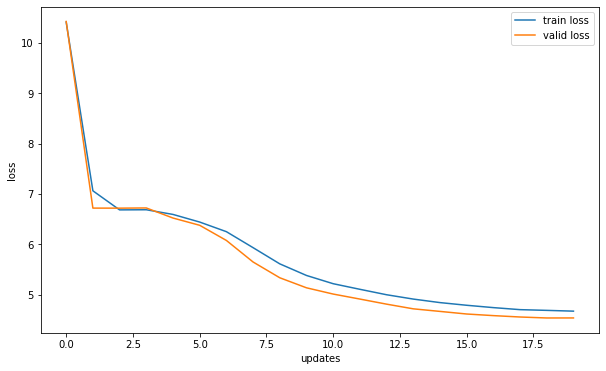

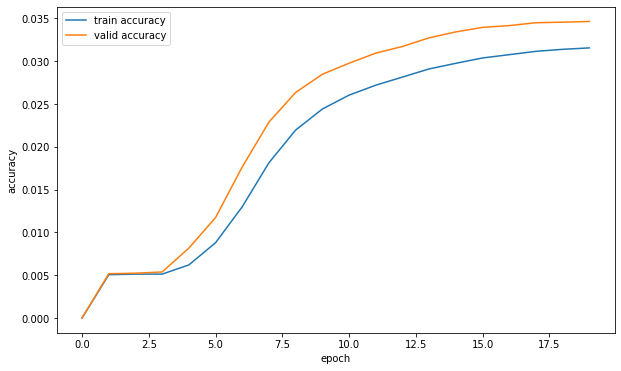

In [ ]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.plot(save_epoch_train_losses, label='train loss')
ax.plot(save_epoch_valid_losses, label='valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.plot(save_epoch_train_accs, label='train accuracy')
ax.plot(save_epoch_valid_accs, label='valid accuracy')
plt.legend()
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy');

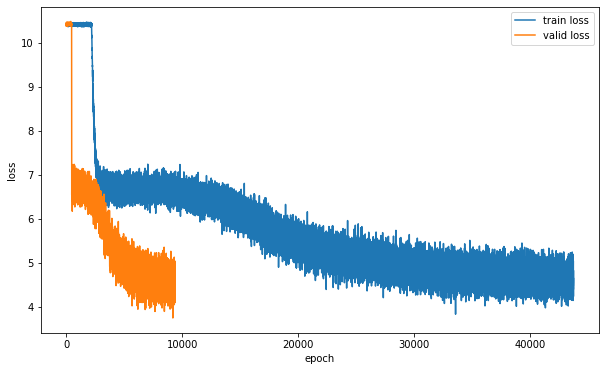

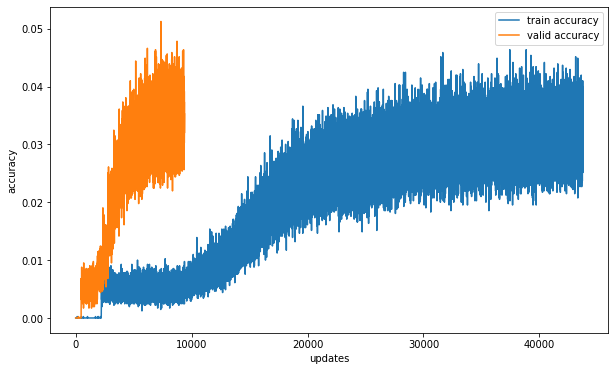

In [ ]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.plot(train_losses, label='train loss')
ax.plot(valid_losses, label='valid loss')
plt.legend()
ax.set_xlabel('epoch')
ax.set_ylabel('loss')

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.plot(train_accs, label='train accuracy')
ax.plot(valid_accs, label='valid accuracy')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('accuracy');

In [ ]:
transformer = TransformerEncoder(len(tokenizer), hidden=256, n_layers=3, attn_heads=4, dropout=0.1)
model = Transformer(transformer, vocab_size, freeze=True)
model.load_state_dict(torch.load('/content/drive/MyDrive/ECE 661/final project/MLM_pretrain.pt'))
model.to(device)
test_loss, test_acc = evaluate(test_dataloader, model, criterion, device)

epoch_test_loss = np.mean(test_loss)
epoch_test_acc = np.mean(test_acc)
print(f'valid_loss: {epoch_test_loss:.3f}, valid_acc: {epoch_test_acc:.3f}')

evaluating...: 100%|██████████| 469/469 [00:40<00:00, 11.69it/s]
valid_loss: 4.520, valid_acc: 0.035


# Fine Tune

In [ ]:
# Start training
best_valid_loss = float('inf')
train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

save_epoch_train_losses = []
save_epoch_valid_losses = []
save_epoch_train_accs = []
save_epoch_valid_accs = []

In [ ]:
# Load pre-train data
train_data = IMDB(x_train, y_train, tokenizer, MAX_LENGTH, mode="fine-tune")
valid_data = IMDB(x_valid, y_valid, tokenizer, MAX_LENGTH, mode="fine-tune")
test_data = IMDB(x_test, y_test, tokenizer, MAX_LENGTH, mode="fine-tune")

collate_finetune = functools.partial(collate_finetune, pad_index=pad_index)
train_dataloader = torch.utils.data.DataLoader(train_data,
                                               batch_size=BATCH_SIZE,
                                               collate_fn=collate_finetune,
                                               shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_data, batch_size=BATCH_SIZE, collate_fn=collate_finetune)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, collate_fn=collate_finetune)

In [ ]:
# Model
FINETUNE = True
transformer = TransformerEncoder(len(tokenizer), hidden=256, n_layers=3, attn_heads=4, dropout=0.1)
model = Transformer(transformer, vocab_size, False)    # finetune the whole BERT
# Optimization
optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = transformers.get_cosine_schedule_with_warmup(optimizer,
                                                         num_warmup_steps = N_EPOCHS//2,
                                                         num_training_steps = N_EPOCHS)
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = criterion.to(device)

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/ECE 661/final project/MLM_pretrain.pt'))
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 10,184,194 trainable parameters


In [ ]:
N_EPOCHS = 10

In [ ]:
# Start training
best_valid_loss = float('inf')
train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

for epoch in range(N_EPOCHS):

    train_loss, train_acc = train(train_dataloader, model, criterion, optimizer, device)
    valid_loss, valid_acc = evaluate(valid_dataloader, model, criterion, device)

    scheduler.step()

    train_losses.extend(train_loss)
    train_accs.extend(train_acc)
    valid_losses.extend(valid_loss)
    valid_accs.extend(valid_acc)

    epoch_train_loss = np.mean(train_loss)
    epoch_train_acc = np.mean(train_acc)
    save_epoch_train_losses.append(epoch_train_loss)
    save_epoch_train_accs.append(epoch_train_acc)

    epoch_valid_loss = np.mean(valid_loss)
    epoch_valid_acc = np.mean(valid_acc)
    save_epoch_valid_losses.append(epoch_valid_loss)
    save_epoch_valid_accs.append(epoch_valid_acc)

    if epoch_valid_loss < best_valid_loss:
        best_valid_loss = epoch_valid_loss
        torch.save(model.state_dict(), '/content/drive/MyDrive/ECE 661/final project/MLM_finetuned.pt')

    print(f'epoch: {epoch+1}')
    print(f'train_loss: {epoch_train_loss:.3f}, train_acc: {epoch_train_acc:.3f}')
    print(f'valid_loss: {epoch_valid_loss:.3f}, valid_acc: {epoch_valid_acc:.3f}')



evaluating...: 100%|██████████| 469/469 [00:11<00:00, 42.62it/s]
epoch: 1
train_loss: 0.796, train_acc: 0.503
valid_loss: 0.931, valid_acc: 0.496
evaluating...: 100%|██████████| 469/469 [00:11<00:00, 42.54it/s]
epoch: 2
train_loss: 0.633, train_acc: 0.637
valid_loss: 0.540, valid_acc: 0.733
evaluating...: 100%|██████████| 469/469 [00:10<00:00, 42.70it/s]
epoch: 3
train_loss: 0.490, train_acc: 0.764
valid_loss: 0.399, valid_acc: 0.828
evaluating...: 100%|██████████| 469/469 [00:11<00:00, 42.58it/s]
epoch: 4
train_loss: 0.403, train_acc: 0.816
valid_loss: 0.387, valid_acc: 0.834
evaluating...: 100%|██████████| 469/469 [00:11<00:00, 42.54it/s]
epoch: 5
train_loss: 0.361, train_acc: 0.840
valid_loss: 0.384, valid_acc: 0.856
evaluating...: 100%|██████████| 469/469 [00:11<00:00, 42.42it/s]
epoch: 6
train_loss: 0.329, train_acc: 0.857
valid_loss: 0.353, valid_acc: 0.861
evaluating...: 100%|██████████| 469/469 [00:11<00:00, 42.21it/s]
epoch: 7
train_loss: 0.306, train_acc: 0.869
valid_loss: 0.

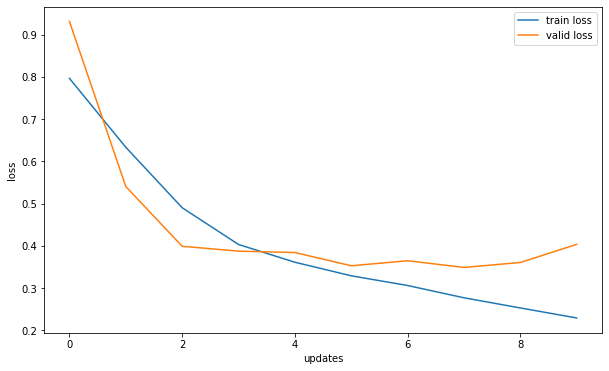

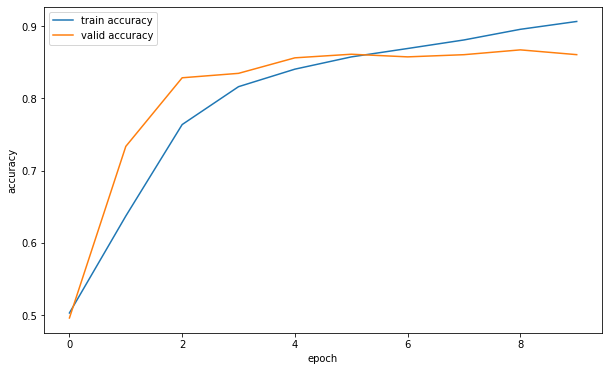

In [ ]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.plot(save_epoch_train_losses, label='train loss')
ax.plot(save_epoch_valid_losses, label='valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.plot(save_epoch_train_accs, label='train accuracy')
ax.plot(save_epoch_valid_accs, label='valid accuracy')
plt.legend()
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy');

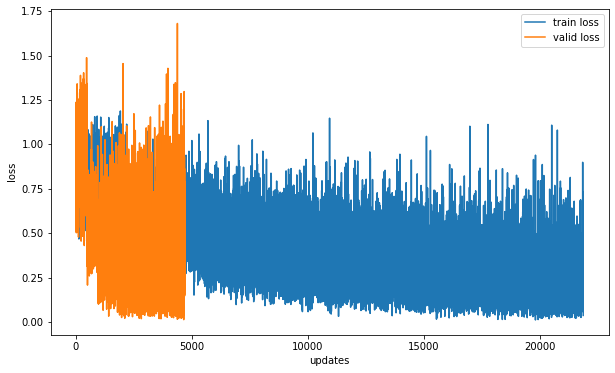

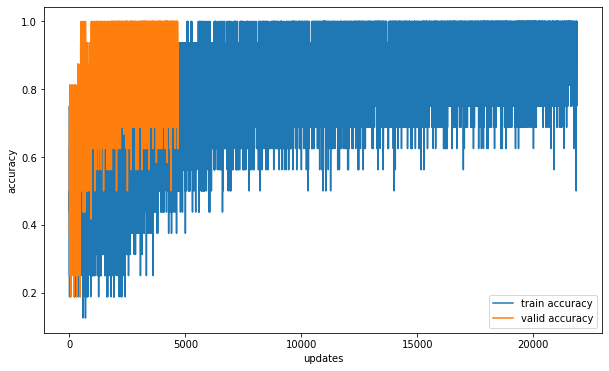

In [ ]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.plot(train_losses, label='train loss')
ax.plot(valid_losses, label='valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.plot(train_accs, label='train accuracy')
ax.plot(valid_accs, label='valid accuracy')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('accuracy');

In [ ]:
transformer = TransformerEncoder(len(tokenizer), hidden=256, n_layers=3, attn_heads=4, dropout=0.1)
model = Transformer(transformer, vocab_size, freeze=True)
model.fc = nn.Linear(model.fc.in_features, 2)  
model.load_state_dict(torch.load('/content/drive/MyDrive/ECE 661/final project/MLM_finetuned.pt'))
model.to(device)
test_loss, test_acc = evaluate(test_dataloader, model, criterion, device)

epoch_test_loss = np.mean(test_loss)
epoch_test_acc = np.mean(test_acc)
print(f'valid_loss: {epoch_test_loss:.3f}, valid_acc: {epoch_test_acc:.3f}')

evaluating...: 100%|██████████| 469/469 [00:11<00:00, 41.96it/s]
valid_loss: 0.344, valid_acc: 0.860
